<a href="https://colab.research.google.com/github/vidhi20/US-Air-Hazards/blob/main/USpollutionHazards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Make plots look nicer
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (9, 6)

# %% [markdown]
# ## 1. Load the dataset

# %%
# CHANGE PATH IF NEEDED
file_path = "/content/pollution_us_2000_2016.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

# Quick peek
df.head()


Shape: (542852, 29)

Columns:
 Index(['Unnamed: 0', 'State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'City', 'Date Local', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI'],
      dtype='object')


,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21.0,13.0,Parts per million,1.145833,4.2,21.0,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21.0,13.0,Parts per million,0.878947,2.2,23.0,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23.0,NaN,Parts per million,1.145833,4.2,21.0,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23.0,NaN,Parts per million,0.878947,2.2,23.0,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22.0,4.0,Parts per million,0.850000,1.6,23.0,NaN


In [ ]:
# %% [markdown]
# ## 2. Basic cleaning and selection
# We focus on:
# - Location: State, City
# - Date
# - Pollutant means: NO2, O3, SO2, CO

# %%
# Drop useless index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Parse date
df["Date Local"] = pd.to_datetime(df["Date Local"], errors="coerce")

# Keep rows with valid City and State
df = df.dropna(subset=["State", "City"])

# Remove the pseudo-location "Not in a city" to avoid noise
df = df[df["City"].str.strip().str.lower() != "not in a city"]

pollutant_cols = ["NO2 Mean", "O3 Mean", "SO2 Mean", "CO Mean"]

print("Number of states:", df["State"].nunique())
print("Number of cities:", df["City"].nunique())
df[pollutant_cols].describe()


Number of states: 22
Number of cities: 90


,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
count,514848.000000,514847.000000,514847.000000,514847.000000
mean,16.644766,0.025375,3.059487,0.493365
std,10.635889,0.012068,3.644857,0.408138
min,0.000000,0.000000,0.000000,0.000000
25%,8.916667,0.016417,0.687500,0.241667
50%,14.736842,0.025042,1.956522,0.404167
75%,22.250000,0.033542,4.095238,0.639130
max,139.541667,0.095083,81.250000,7.508333


In [ ]:
# %% [markdown]
# ## 3. Aggregate to City–State level
# For each State–City pair, we compute the average pollutant concentration over 2000–2016.
# This gives each city a single pollution profile.

# %%
city_agg = (
    df.groupby(["State", "City"])[pollutant_cols]
      .mean()
      .reset_index()
)

print("City-level rows:", city_agg.shape[0])
city_agg.head()


City-level rows: 90


,State,City,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
0,Arizona,Phoenix,25.649851,0.023087,2.324526,0.758892
1,Arizona,Scottsdale,25.596129,0.017991,1.838379,0.695095
2,Arizona,Tucson,16.054349,0.026675,1.100287,0.396940
3,California,Arden-Arcade,13.804946,0.026887,1.727158,0.522881
4,California,Bakersfield,28.987914,0.016640,1.928080,0.825968


In [ ]:
# %% [markdown]
# ## 4. Build a "pollution index" and pollutant contribution percentages
#
# Idea:
# - Normalize each pollutant to [0,1] across cities (min–max)
# - For each city, sum normalized pollutants → Pollution Index
# - For each pollutant, compute its share:
#     contribution_% = pollutant_norm / sum(all_pollutants_norm)
#
# This gives an **easy-to-explain** view:
# > In City X, pollution is 40% due to NO2, 35% O3, etc.

# %%
# Min–max normalization across cities (for contribution calculation)
X_norm = (city_agg[pollutant_cols] - city_agg[pollutant_cols].min()) / (
    city_agg[pollutant_cols].max() - city_agg[pollutant_cols].min()
)

# Overall pollution index for each city (higher = more polluted)
pollution_index = X_norm.sum(axis=1)

# Avoid division by zero
pollution_index = pollution_index.replace(0, np.nan)

contrib = X_norm.div(pollution_index, axis=0)  # fraction per pollutant
contrib = contrib.fillna(0.0)

# Save to city_agg
city_agg["pollution_index"] = pollution_index
for col in pollutant_cols:
    city_agg[f"{col}_contrib"] = contrib[col]

city_agg.head()


,State,City,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,pollution_index,NO2 Mean_contrib,O3 Mean_contrib,SO2 Mean_contrib,CO Mean_contrib
0,Arizona,Phoenix,25.649851,0.023087,2.324526,0.758892,2.071032,0.344550,0.178725,0.103550,0.373174
1,Arizona,Scottsdale,25.596129,0.017991,1.838379,0.695095,1.775807,0.400959,0.106950,0.094573,0.397517
2,Arizona,Tucson,16.054349,0.026675,1.100287,0.396940,1.424443,0.306785,0.348947,0.068327,0.275942
3,California,Arden-Arcade,13.804946,0.026887,1.727158,0.522881,1.559237,0.238682,0.323595,0.100885,0.336839
4,California,Bakersfield,28.987914,0.016640,1.928080,0.825968,1.971685,0.410710,0.072086,0.089531,0.427674


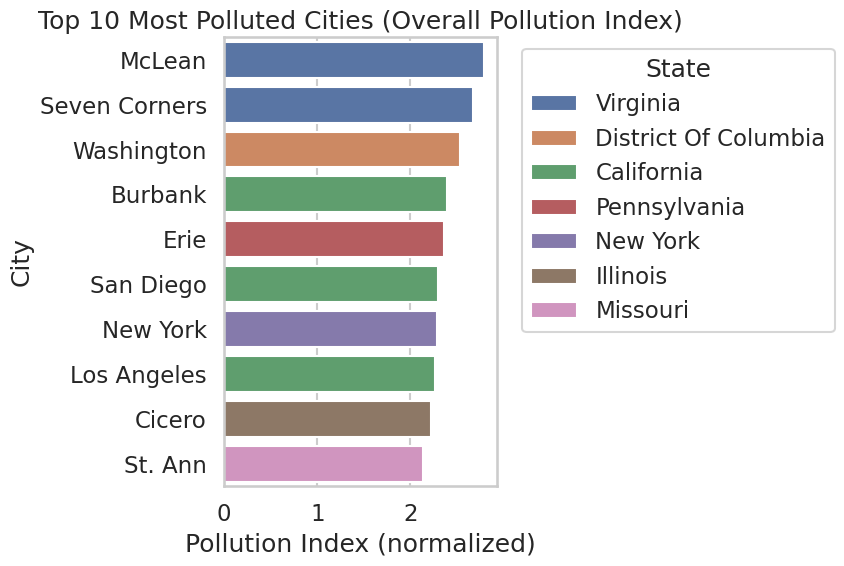

In [ ]:
# %% [markdown]
# ### 4.1. Visual: Top 10 most polluted cities (by pollution index)

# %%
top10 = (
    city_agg.sort_values("pollution_index", ascending=False)
            .head(10)
)

plt.figure()
sns.barplot(
    data=top10,
    x="pollution_index",
    y="City",
    hue="State",
    dodge=False
)
plt.title("Top 10 Most Polluted Cities (Overall Pollution Index)")
plt.xlabel("Pollution Index (normalized)")
plt.ylabel("City")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


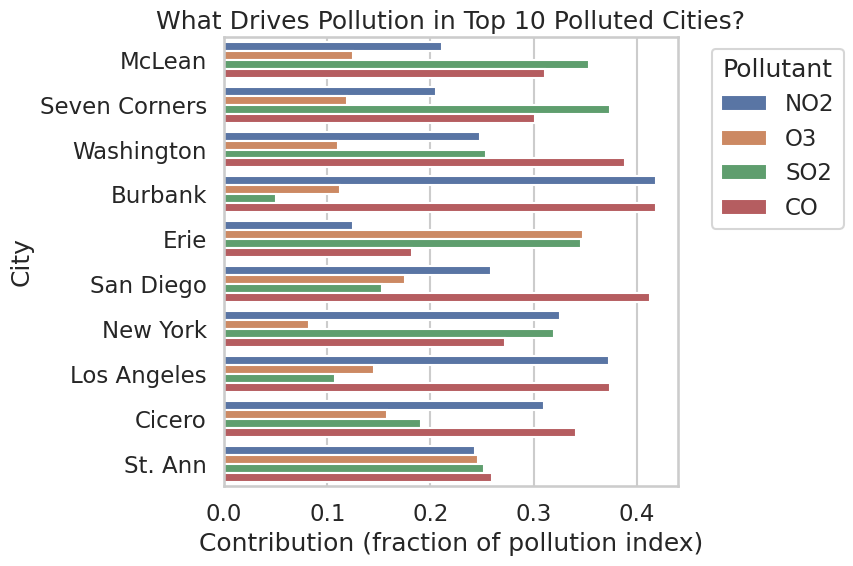

In [ ]:
# %% [markdown]
# ### 4.2. Visual: Example cities – what causes their pollution?
#
# We take a few of the top polluted cities and show the percentage contribution of each pollutant.

# %%
example_cities = top10.copy()

# Melt the contribution columns for stacked bar
contrib_cols = [f"{c}_contrib" for c in pollutant_cols]
tmp = example_cities[
    ["State", "City"] + contrib_cols
].copy()

tmp_melt = tmp.melt(id_vars=["State", "City"],
                    value_vars=contrib_cols,
                    var_name="Pollutant",
                    value_name="Contribution")

# Make pollutant names prettier
tmp_melt["Pollutant"] = tmp_melt["Pollutant"].str.replace(" Mean_contrib", "", regex=False)
tmp_melt["Pollutant"] = tmp_melt["Pollutant"].str.replace(" Mean", "", regex=False)

plt.figure()
sns.barplot(
    data=tmp_melt,
    x="Contribution",
    y="City",
    hue="Pollutant"
)
plt.title("What Drives Pollution in Top 10 Polluted Cities?")
plt.xlabel("Contribution (fraction of pollution index)")
plt.ylabel("City")
plt.legend(title="Pollutant", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



In [ ]:
# %% [markdown]
# ## 5. Prepare data for PCA & clustering
#
# For clustering, we use the actual mean pollutant values (not min–max).
# We standardize them (zero mean, unit variance) before PCA/KMeans.

# %%
features = pollutant_cols

X = city_agg[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of feature matrix:", X_scaled.shape)


Shape of feature matrix: (90, 4)


Explained variance ratio by component: [0.60320143 0.23814871 0.09815749 0.06049236]
Cumulative: [0.60320143 0.84135015 0.93950764 1.        ]


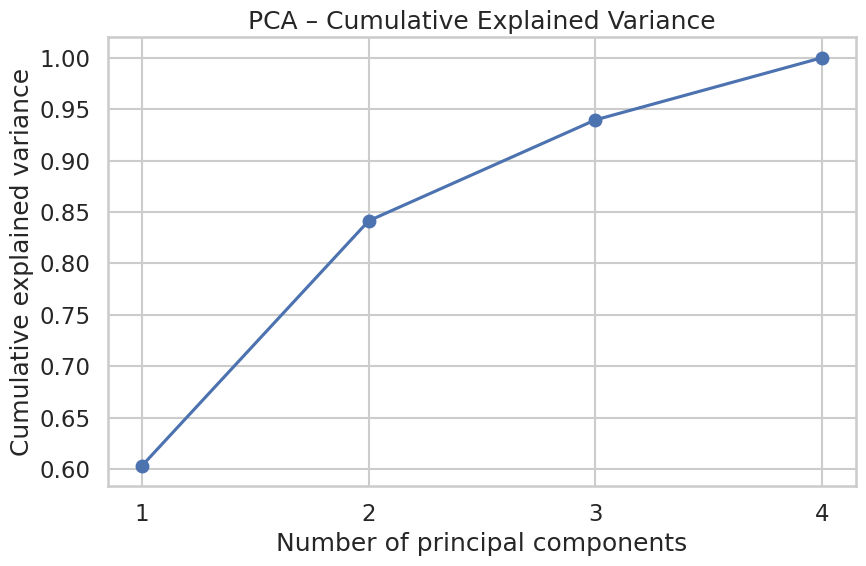

In [ ]:
# %% [markdown]
# ## 6. Principal Component Analysis (PCA)
#
# PCA helps us:
# - Reduce to 2D for visualization
# - Understand which directions (combinations of pollutants) explain most variation

# %%
pca = PCA(n_components=len(features))
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
print("Explained variance ratio by component:", explained)
print("Cumulative:", np.cumsum(explained))

# Scree plot
plt.figure()
plt.plot(range(1, len(features)+1), np.cumsum(explained), marker="o")
plt.xticks(range(1, len(features)+1))
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA – Cumulative Explained Variance")
plt.tight_layout()
plt.show()


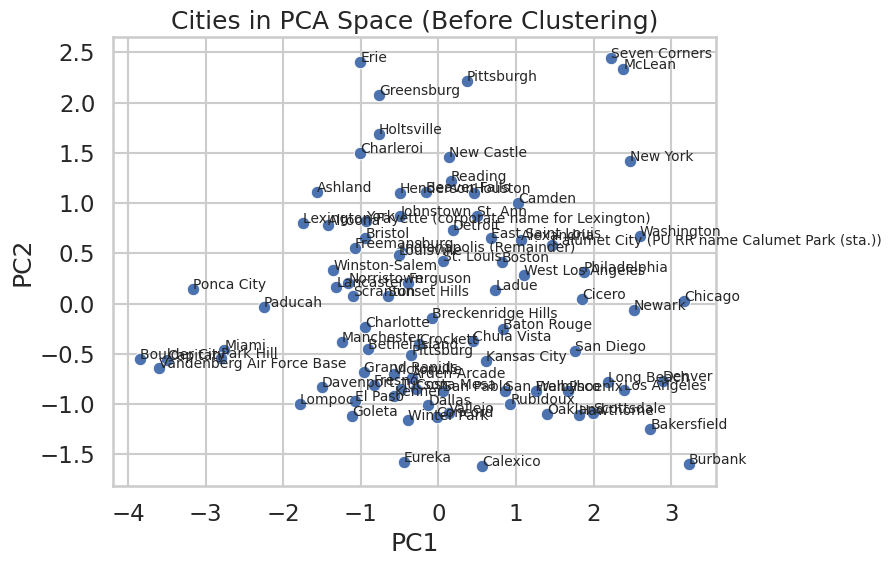

In [ ]:
# %% [markdown]
# ### 6.1. PCA scatter (no clusters yet)

# %%
plt.figure()
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1]
)
for i, row in city_agg.iterrows():
    plt.text(X_pca[i, 0], X_pca[i, 1],
             row["City"],
             fontsize=10,
             alpha=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cities in PCA Space (Before Clustering)")
plt.tight_layout()
plt.show()



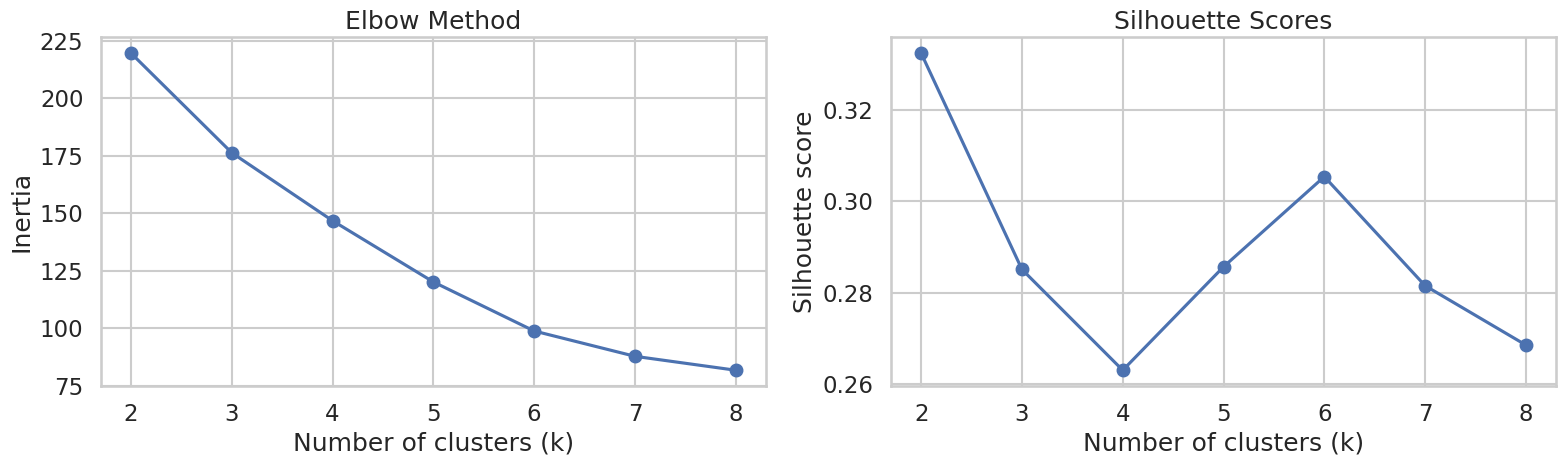

k=2: silhouette=0.332
k=3: silhouette=0.285
k=4: silhouette=0.263
k=5: silhouette=0.286
k=6: silhouette=0.305
k=7: silhouette=0.282
k=8: silhouette=0.269


In [ ]:
# %% [markdown]
# ## 7. KMeans clustering
#
# We use:
# - **Elbow method** (inertia) to see where adding clusters stops helping much
# - **Silhouette score** to measure how well-separated clusters are

# %%
inertias = []
sil_scores = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(list(K_range), inertias, marker="o")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Elbow Method")

ax[1].plot(list(K_range), sil_scores, marker="o")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Silhouette Scores")

plt.tight_layout()
plt.show()

for k, sil in zip(K_range, sil_scores):
    print(f"k={k}: silhouette={sil:.3f}")


In [ ]:
# %% [markdown]
# ### 7.1. Fit final KMeans model
# Pick k based on elbow + silhouette.
# (You can adjust this after looking at the plots.)

# %%
optimal_k = 4  # <-- change if needed after inspecting above output

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
city_agg["cluster_kmeans"] = final_kmeans.fit_predict(X_scaled)

city_agg["cluster_kmeans"].value_counts()


,count
cluster_kmeans,
3,29
1,25
0,21
2,15


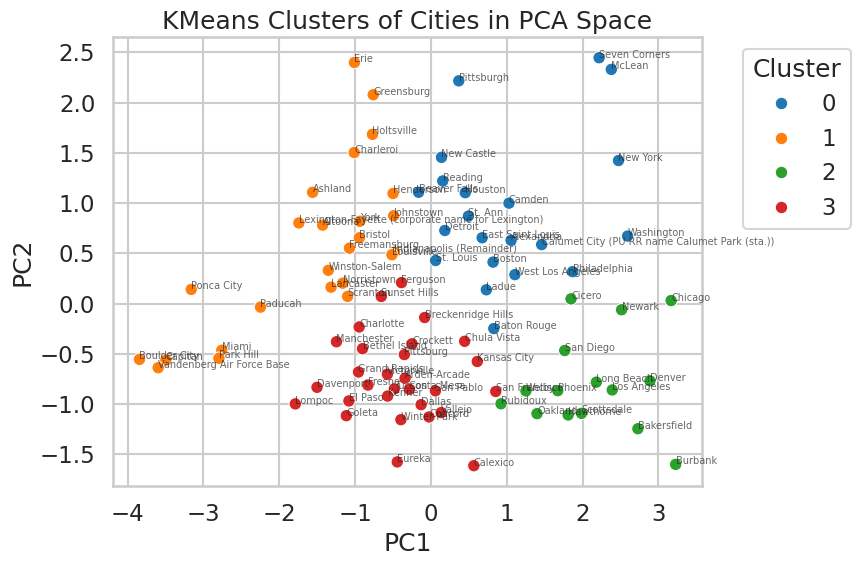

In [ ]:
# %% [markdown]
# ### 7.2. Visual: Clusters in PCA space

# %%
plt.figure()
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=city_agg["cluster_kmeans"],
    palette="tab10",
    s=80
)
for i, row in city_agg.iterrows():
    plt.text(X_pca[i, 0],
             X_pca[i, 1],
             row["City"],
             fontsize=7,
             alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters of Cities in PCA Space")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# %% [markdown]
# ### 7.3. Cluster profiles – which clusters are "dirtier" and how?
#
# We look at mean pollutant levels per cluster and show:
# - A table of cluster averages
# - A heatmap for easy comparison

# %%
cluster_mean = (
    city_agg.groupby("cluster_kmeans")[features + ["pollution_index"]]
            .mean()
            .round(3)
)

cluster_mean


,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,pollution_index
cluster_kmeans,,,,,
0,19.728,0.023,6.016,0.524,2.001
1,10.693,0.031,3.665,0.206,1.478
2,26.587,0.020,2.694,0.761,2.022
3,13.129,0.026,1.648,0.489,1.479


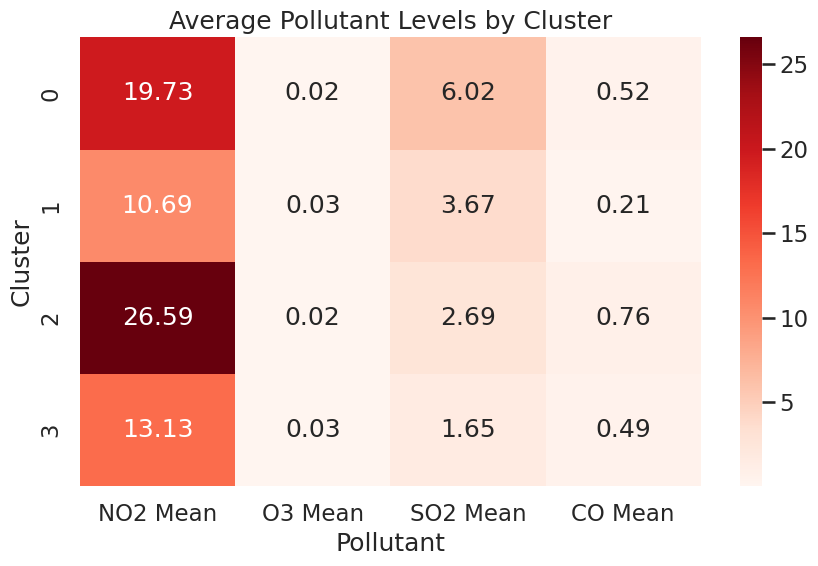

In [ ]:
# %%
plt.figure()
sns.heatmap(
    cluster_mean[features],
    annot=True,
    fmt=".2f",
    cmap="Reds"
)
plt.title("Average Pollutant Levels by Cluster")
plt.xlabel("Pollutant")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


In [ ]:
# %% [markdown]
# ### 7.4. Cluster-wise pollution cause mix
#
# For each cluster, we average the contribution percentages.
# This shows which pollutants are **main drivers** of pollution in each cluster.

# %%
contrib_cols = [f"{c}_contrib" for c in pollutant_cols]

cluster_contrib = (
    city_agg.groupby("cluster_kmeans")[contrib_cols]
            .mean()
)

# Make columns nicer for plotting
cluster_contrib_plt = cluster_contrib.copy()
cluster_contrib_plt.columns = [c.replace(" Mean_contrib", "") for c in cluster_contrib_plt.columns]
cluster_contrib_plt.columns = [c.replace(" Mean", "") for c in cluster_contrib_plt.columns]

cluster_contrib_plt


,NO2,O3,SO2,CO
cluster_kmeans,,,,
0,0.274272,0.185828,0.281633,0.258267
1,0.187243,0.479975,0.213694,0.119087
2,0.367141,0.125702,0.123619,0.383538
3,0.236142,0.332908,0.096502,0.334448


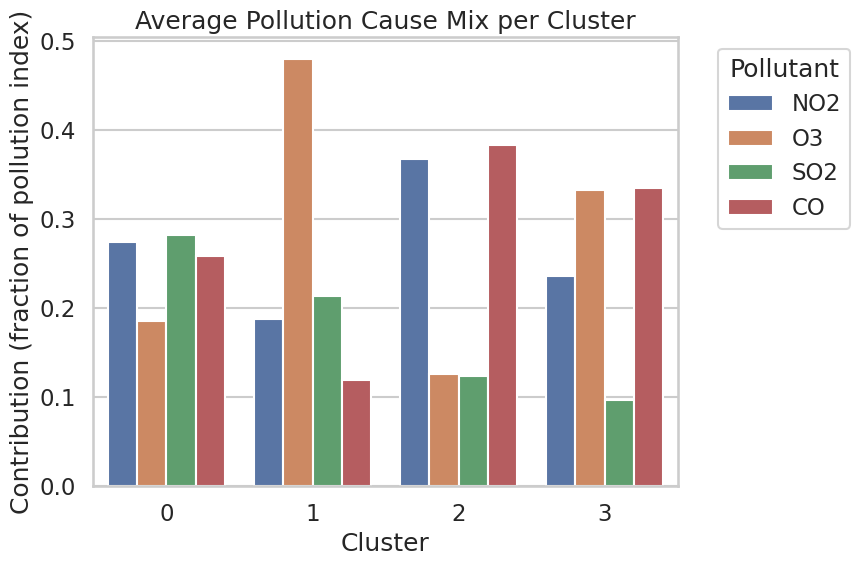

In [ ]:
# %%
cluster_contrib_long = (
    cluster_contrib_plt
    .reset_index()
    .melt(id_vars="cluster_kmeans", var_name="Pollutant", value_name="Contribution")
)

plt.figure()
sns.barplot(
    data=cluster_contrib_long,
    x="cluster_kmeans",
    y="Contribution",
    hue="Pollutant"
)
plt.title("Average Pollution Cause Mix per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Contribution (fraction of pollution index)")
plt.legend(title="Pollutant", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# %% [markdown]
# ### 7.5. Which cities fall into each cluster?
# This is useful for managers/policymakers:
# > "Cluster 0 = high NO2/CO cities (traffic + combustion heavy), includes: X, Y, Z..."

# %%
for cl in sorted(city_agg["cluster_kmeans"].unique()):
    subset = city_agg[city_agg["cluster_kmeans"] == cl]
    print(f"\n=== Cluster {cl} ===")
    print(subset[["State", "City", "pollution_index"]]
          .sort_values("pollution_index", ascending=False)
          .head(15)
          .to_string(index=False))



=== Cluster 0 ===
               State                                          City  pollution_index
            Virginia                                        McLean         2.789791
            Virginia                                 Seven Corners         2.670002
District Of Columbia                                    Washington         2.535360
            New York                                      New York         2.280919
            Missouri                                       St. Ann         2.136732
          California                              West Los Angeles         2.105762
        Pennsylvania                                    Pittsburgh         2.105505
          New Jersey                                        Camden         2.095656
            Missouri                                     St. Louis         1.982464
            Illinois Calumet City (PU RR name Calumet Park (sta.))         1.981983
            Virginia                                    A

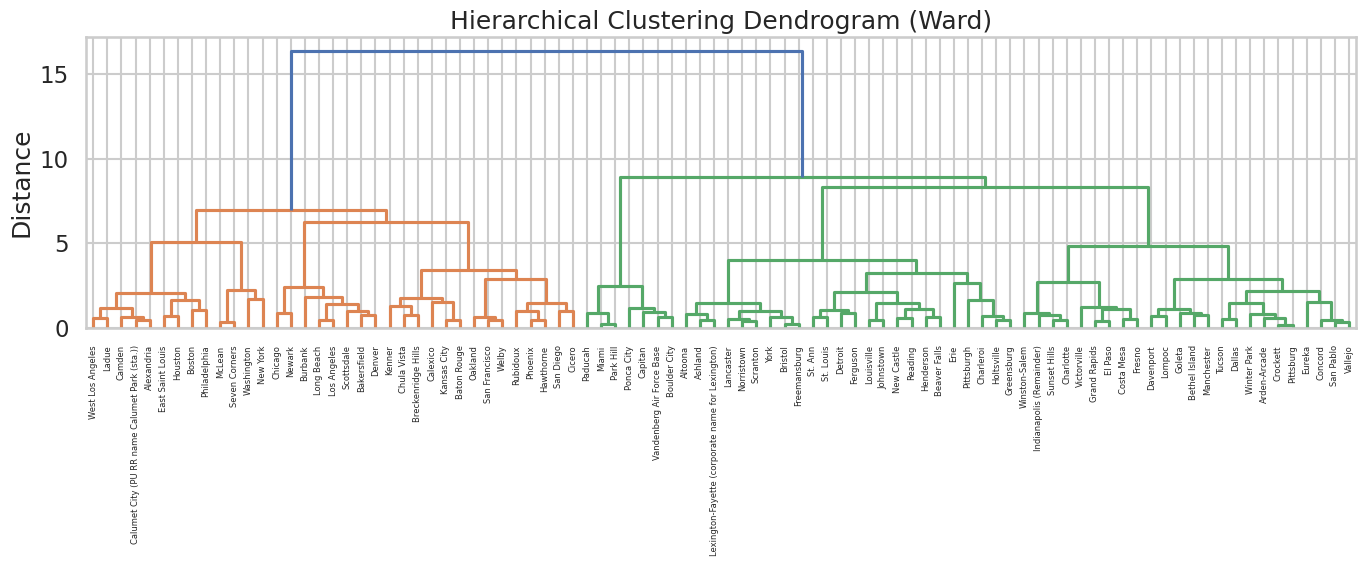

cluster_hier,1,2,3,4
cluster_kmeans,,,,
0,14,0,7,0
1,0,7,16,2
2,15,0,0,0
3,6,0,1,22


In [ ]:
# %% [markdown]
# ## 8. (Optional) Hierarchical clustering
# For comparison, we can also do hierarchical clustering with Ward linkage.

# %%
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=city_agg["City"].values,
    leaf_rotation=90,
    leaf_font_size=6
)
plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Choose same number of clusters for comparison
city_agg["cluster_hier"] = fcluster(Z, t=optimal_k, criterion="maxclust")
pd.crosstab(city_agg["cluster_kmeans"], city_agg["cluster_hier"])
